# Larceny and thefts are clustered in an area that spans three police districts in San Francisco

The goal of this study was to analyse the **most common crime** reported in San Francisco and assess if there are **geographical locations** where these crimes are *clustered*.

The data used to performed this study is the San Francisco Summer 2014 dataset supplied as part of this assignment.  

**Key Findings:**
* **Larceny/Thefts** are the most common crime types reported in the city
* The **Southern** police district receives the most number of such crime reports
* There is a distinct clustering of larceny/thefts crime reports in an area spanning the **Southern, Tenderloin and Central** police districts.


In [1]:
import sys,os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import calendar
%matplotlib inline

df=pd.read_csv("data/sanfrancisco_incidents_summer_2014.csv")
## Change data type for date
df["Date"] = pd.to_datetime(df.Date)
df['Month'] = df.Date.dt.month.apply(lambda x: calendar.month_abbr[x])


The following function sorts by a nominated category and plots a bar graph showing based on the sorted values.

We find that the **Larceny/Theft** category is by far the most reported crime category over this period of San Francisco.

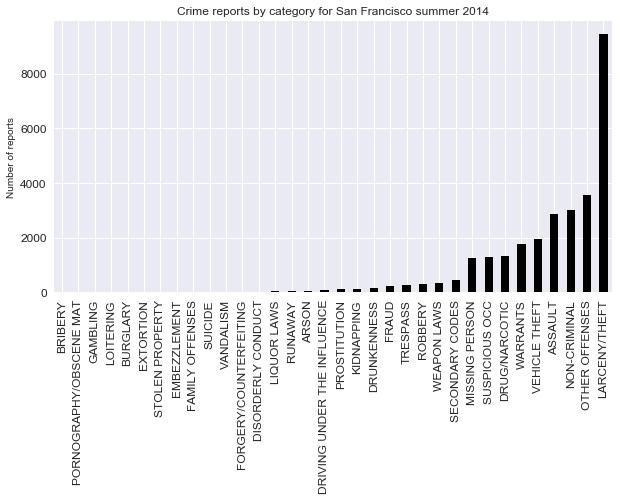

In [2]:
def plotdat(data,cat, title):
    l=data.groupby(cat).size()
    l.sort_values(inplace=True)
    fig=plt.figure(figsize=(10,5))
    plt.yticks(fontsize=8)
    l.plot(kind='bar',fontsize=12,color='k')
    plt.title(title)
    plt.xlabel('')
    plt.ylabel('Number of reports',fontsize=10)

plotdat(df,'Category','Crime reports by category for San Francisco summer 2014')

### Let's drill down into the Larceny/Theft category
We isolate the data and redraw the plot to asses which Police District receive the most crime reports for this category.

The **Southern** police district appears to receive a disproportionate number of larceny/theft crime reports compared to other police districts; followed closely by Central and Northern districts.

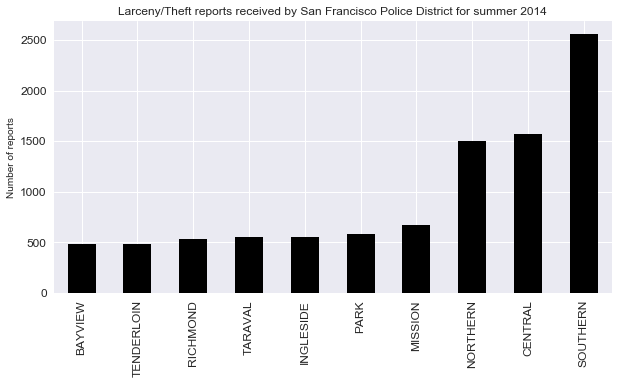

In [3]:
cat=df[df['Category']=='LARCENY/THEFT']

plotdat(cat,'PdDistrict', 'Larceny/Theft reports received by San Francisco Police District for summer 2014')

### Is there are pattern of crimes over the summer of 2014?

The plot below shows that more larceny/theft crimes were reported in **August** and there was an pattern of increasing number of crimes reported per month as the summer of 2014 progresses.

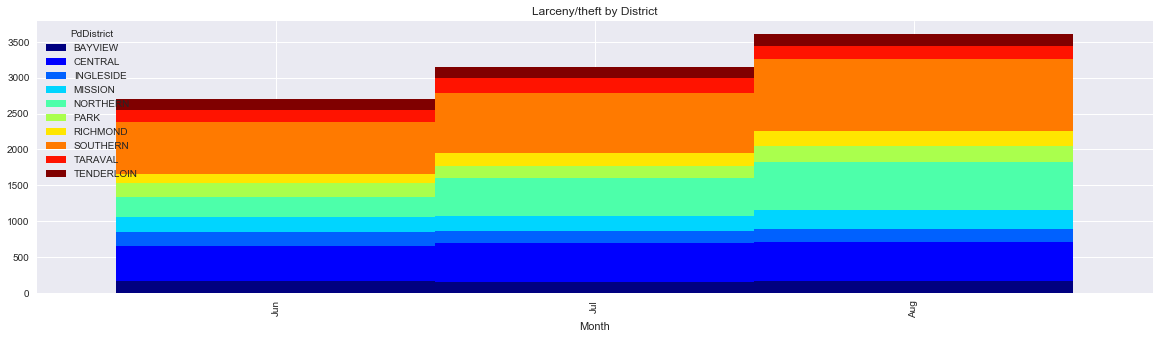

In [4]:
cat_per_month=cat.groupby('Month').PdDistrict.value_counts(sort=True)
t = cat_per_month.unstack().fillna(0)
t = t.reindex(['Jun','Jul','Aug'])
colors =  plt.cm.jet(np.linspace(0,1,10)) 
t.plot(kind='bar',stacked=True, figsize=(20,5), color=colors, width=1, title='Larceny/theft by District',fontsize=10);



A cursory visual analysis of shows distinct spikes in all there summer months when larceny/theft crimes are reported.

An interesting analysis would be to assess whether there were particular big events on around this time or whether there is any correlation between weather conditions and number of crime reports.

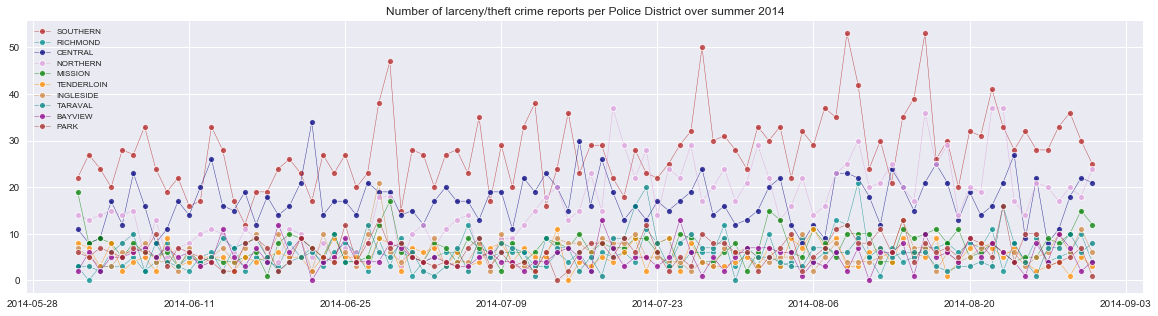

In [5]:
cat_per_day=cat.groupby('Date').PdDistrict.value_counts(sort=True)
t = cat_per_day.unstack().fillna(0)

district_list = cat.PdDistrict.unique()

sns.set_context(rc={"figure.figsize": (20,5)})
for d,c in zip(['SOUTHERN', 'RICHMOND', 'CENTRAL', 'NORTHERN', 'MISSION',
       'TENDERLOIN', 'INGLESIDE', 'TARAVAL', 'BAYVIEW', 'PARK'],
               ['firebrick','darkcyan','navy','plum','g','darkorange','peru','teal','darkmagenta','brown']):
    plt.plot(t.index,t[d],'o-',color=c,ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8});
plt.title("Number of larceny/theft crime reports per Police District over summer 2014");


### Geospatial Analysis of Larceny/Theft crimes in San Francisco

Applying a kernel density estimate (kde) analysis over the locations where all larcerny/theft crimes were reported shows a distinct clustering of these crime reports over the downtown area in San Francisco.  

Interestingly, this clustering is shown to be shared by three police districts: **Southern, Tenderloin and Central**.

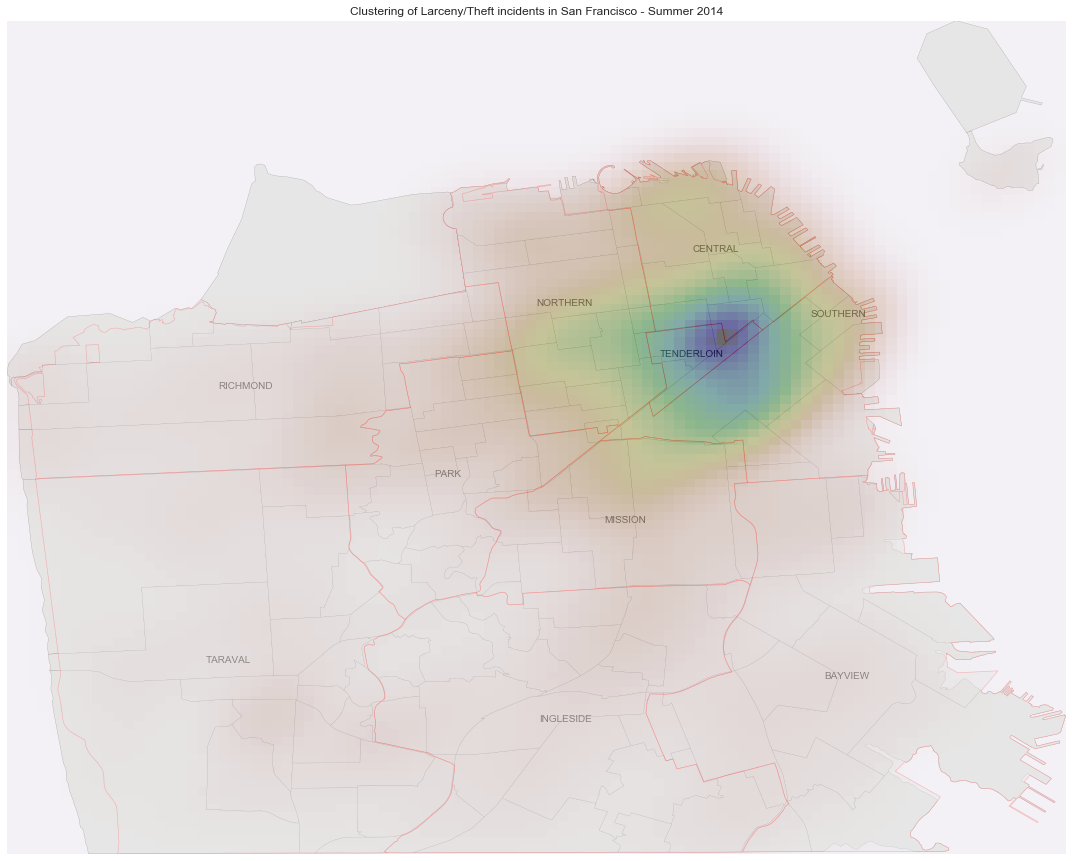

In [8]:
import fiona
from fiona.crs import from_epsg
from shapely.geometry import shape, mapping
from pyproj import Proj, transform
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from descartes import PolygonPatch
from itertools import chain
import scipy.stats as stats
from matplotlib.collections import PatchCollection


# read in the shape file for the San Francisco neighbourhoods
mp = MultiPolygon(
    [shape(pol['geometry']) for pol in fiona.open('data/geo_export_sanfran_neighbourhoods.shp')])

pdDistrict = MultiPolygon(
    [shape(pol['geometry']) for pol in fiona.open('data/geo_export_police_districts.shp')])

## Work out centroid points and labels
pdDistrictLabels = {}    
for pol in fiona.open('data/geo_export_police_districts.shp'):
    pdDistrictCentroid = shape(pol['geometry']).centroid.coords[0]
    pdDistrictLabels[pol['properties']['district']]=pdDistrictCentroid
    
# work out the the min and max of the x and y 
xmin, ymin, xmax, ymax = mp.bounds

# Calculate the KDE using the min and max bounds of the shape file
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([cat["X"], cat["Y"]])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

# load the polygon into PolygonPatch for rendering
patches = []
for idx, p in enumerate(mp):
    patches.append(PolygonPatch(p, fc='lightgray', ec='black', lw=0.2, alpha=1.0, zorder=1))

# load the police districts for rendering
police = []
for idx, p in enumerate(pdDistrict):
    police.append(PolygonPatch(p, fc='lightgray',ec='red', lw=0.6, alpha=0.5 ,zorder=2))

fig = plt.figure()
fig.set_size_inches(15,15)
ax = fig.add_subplot(111)

# add the polygons for each neighbourhood
ax.add_collection(PatchCollection(patches, match_original=True))

# add the polygons for each neighbourhood
ax.add_collection(PatchCollection(police, match_original=True))

# show the KDE clustering of the incidents, with transparency to show the underneath shapes
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
           extent=[xmin, xmax, ymin, ymax],alpha=0.5, zorder=3)

# set the limits and suppressed the ticks to make it look more like a map, not a plot
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xticks([])
ax.set_yticks([])

for k, v in pdDistrictLabels.items():
      ax.annotate(s=k, xy=v, horizontalalignment='center')

plt.title("Clustering of Larceny/Theft incidents in San Francisco - Summer 2014")
plt.tight_layout()
plt.show()

